# ChebGCNs 


Spectral Graph ConvNets<br>
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering<br>
M Defferrard, X Bresson, P Vandergheynst<br>
Advances in Neural Information Processing Systems, 3844-3852, 2016<br>
ArXiv preprint: [arXiv:1606.09375](https://arxiv.org/pdf/1606.09375.pdf) <br>

DOC : https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=cheb#dgl.nn.pytorch.conv.ChebConv

In [1]:
import os
import sys
import time
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import dgl
import networkx as nx
import matplotlib.pyplot as plt

from utils import rescale_L

#import collections
# MAC PROBLEM THAT MAKES THE NOTEBOOK Crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'


sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2

In [2]:
# GPU Compatibility
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
    device=torch.device('cuda:0')
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)
    device=torch.device('cpu')
    

cuda available


# MNIST

In [3]:
# Downloads the dataset if not found locally
from utils import check_mnist_dataset_exists
_ = check_mnist_dataset_exists()

In [4]:
nb_selected_train_data = 512
nb_selected_test_data = 128

train_data = torch.load('mnist/train_data.pt').reshape(60000, 784)
train_data = train_data[:nb_selected_train_data, :]
print(train_data.shape, type(train_data))

train_labels = torch.load('mnist/train_label.pt')
train_labels = train_labels[:nb_selected_train_data]
print(train_labels.shape)

test_data = torch.load('mnist/test_data.pt').reshape(10000, 784)
test_data = test_data[:nb_selected_test_data, :]
print(test_data.shape)

test_labels = torch.load('mnist/test_label.pt')
test_labels = test_labels[:nb_selected_test_data]
print(test_labels.shape)

torch.Size([512, 784]) <class 'torch.Tensor'>
torch.Size([512])
torch.Size([128, 784])
torch.Size([128])


In [5]:
# Import the dataset from file
from Dataset import MNISTDataset

In [6]:
trainset = MNISTDataset(train_data,train_labels)
testset = MNISTDataset(test_data,test_labels)

## Convolution layer and classifier


In [7]:
from model import Classifier

In [8]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

# Debug section
Verifying all of the steps

g, l = collate((trainset[0], trainset[1]))
net = Classifier(1,200,trainset.num_classes,k=5).to(torch.device('cuda:0'))
print("-------------------- Network model --------------------\n", net)

t = time.time()
## Calculate L 
g.to(torch.device('cuda:0')) 
L,lmax = laplacian(g)
L = rescale_L(L).to(torch.device('cuda:0')) 
print('L',L,'size:',len(L),'time',time.time()-t,L.dtype)
print('Lmax',lmax,len(lmax))


print("\n --------------------  Output for graph g:  --------------------\n", net(g,L))

L,lmax = laplacian(g)

L

# Model definition for training

In [9]:
net = Classifier(1, 200, trainset.num_classes,k=15)
print(net)
if torch.cuda.is_available():
    net.to(device)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=15, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=480, out_features=200, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=200, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


# Training pipe

In [10]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=64,
                         shuffle=True, collate_fn=collate)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

## Training time

In [11]:
epoch_losses = []
net.train()
from utils import laplacian
#torch.autograd.set_detect_anomaly(True)

# This line is way too long computationally! ----------------------
        
for epoch in range(20):
    epoch_loss = 0
    t0 = time.time()
    for iter, (bg, label) in enumerate(data_loader):
        if (iter == 0): 
            L , lmax = laplacian(bg)
            L = rescale_L(L).to(torch.device('cuda:0')) 
        if torch.cuda.is_available():
            bg.to(device) # torch.device('cuda:0')
        if (iter == 0): t = time.time()
        prediction = net(bg,L)
        if (iter == 0): print('prediction time:',time.time()-t )
        if (iter == 0): t = time.time()
        # print("Prediction:", prediction,'len:',prediction.size())  #DEBUG
        loss = loss_func(prediction, label.to(device))
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        if (iter == 0): print('optimizer time:',time.time()-t )
        if (iter == 0): t = time.time()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}, in {:.2f}(s) '.format(
        epoch, epoch_loss, time.time()-t0))
    epoch_losses.append(epoch_loss)

/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


prediction time: 0.9629108905792236
optimizer time: 0.3984506130218506
Epoch 0, loss 2.3491, in 9.52(s) 
prediction time: 0.39241671562194824
optimizer time: 0.4250810146331787


KeyboardInterrupt: 

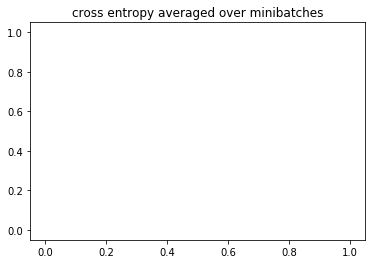

In [13]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

## Test Metrics

In [17]:
# BATCHED DGL EXAMPLE
import sklearn
from sklearn.metrics import classification_report
# Change 

net.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X).to(torch.device('cuda:0'))
test_Y = torch.tensor(test_Y).float().view(-1, 1)
L= rescale_L(torch.from_numpy(nx.normalized_laplacian_matrix(
    test_bg.to_networkx().to_undirected()).todense()).float()).to(torch.device('cuda:0')) # This operation takes 3 seconds

probs_Y = torch.softmax(net(test_bg,L), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

#sklearn.metrics.classification_report(test_Y,argmax_Y)

print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

[autoreload of utils failed: Traceback (most recent call last):
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if

RuntimeError: CUDA out of memory. Tried to allocate 37.52 GiB (GPU 0; 10.92 GiB total capacity; 44.00 MiB already allocated; 10.28 GiB free; 68.00 MiB reserved in total by PyTorch)

## Saving

In [24]:
from utils import save_model
save_model('Model1', net)

[autoreload of utils failed: Traceback (most recent call last):
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if

# Others

$h_i^{l+1}$ &= $\sum_{k=0}^{K-1} W^{k, l}z_i^{k, l}$

$Z^{0, l}$ &= $H^{l}$

$Z^{1, l}$ &=$ \hat{L} \cdot H^{l}$

$Z^{k, l}$ &= $2 \cdot \hat{L} \cdot Z^{k-1, l} - Z^{k-2, l}$

$\hat{L}$ &= $2\left(I - \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}\right)/\lambda_{max} - I$

    Parameters
    ----------
    in_feats: int
        Number of input features.
    out_feats: int
        Number of output features.
    k : int
        Chebyshev filter size.
    bias : bool, optional
        If True, adds a learnable bias to the output. Default: ``True``.